In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<center>
<h1> Apply Feature Aware Normalization to a new dataset </h1>
</center>
&nbsp;
<center>
Daniel Bug and Steffen Schneider<br />
Institute of Imaging & Computer Vision <br />
<pre>steffen.schneider@rwth-aachen.de</pre>
</center>


In this tutorial, we will demonstrate the feature aware normalization module [1] on the digital pathology dataset by [2,3]. Details on the approach are available in our [paper](https://arxiv.org/abs/1708.04099) as well as on the [project page](https://stes.github.io/fan).

If you use this code in your research, please cite our [paper](https://arxiv.org/abs/1708.04099):

```
@incollection{bug2017context,
  title={Context-based Normalization of Histological Stains using Deep Convolutional Features},
  author={Bug, Daniel and Schneider, Steffen and Grote, Anne and Oswald, Eva and Feuerhake, Friedrich and Sch{\"u}ler, Julia and Merhof, Dorit},
  booktitle={Deep Learning in Medical Image Analysis and Multimodal Learning for Clinical Decision Support},
  pages={135--142},
  year={2017},
  publisher={Springer}
}
```

We also have a pre-print available on arxiv: [abs/1708.04099](https://arxiv.org/abs/1708.04099).

## Introduction

Feature Aware Normalization is a technique for normalizing images based on context information estimated by a Feature Extraction Network.
Instead of normal batch normalization layers, in FAN, the shift and scaling parameters $\beta$ and $\gamma$ are functions of a feature representation $z$ computed from the input image.

### Feature Aware Normalization

$$
x' = \frac{x - \mu(x)}{\sqrt{\sigma(x)^2 + \epsilon}} \cdot \gamma(F(x)) + \beta(F(x))
$$

where the image statistics $\mu$ and $\sigma$ are computed over the current batch (or image) $x$ and the shift and scaling parameters are computed on the fly based on a feature representation $F$.

In this demonstration, we parametrized $F$ with the `conv3_3`, `conv4_1` and `conv_4_3` layers of a VGG19 network.
It is straightforward to use other choices for the feature extractor.

### Results

Explore more qualitative results on [stes.github.io/fan](https://stes.github.io/fan).
For a quantiative comparison, please refer to our paper.

![Unnormalized Images](docs/img/BAS_unnormalized_A.jpg)
![FAN normalized Images](docs/img/FAN_HoEoTp_A.jpg)

## Dataset and Network weights

In this tutorial, we will use the dataset released along with our paper:
```
wget https://github.com/stes/fan/releases/download/0.0.1/bug2017_stainnorm_validation_1000px.zip
```

The data is licensed under the [Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0/).

#### Download the data

In [ ]:
! cd data && wget https://github.com/stes/fan/releases/download/0.0.1/bug2017_stainnorm_validation_1000px.zip
# MD5SUM 1491c122c1e0e740a77c4d9f5cc7eb93  bug2017_stainnorm_validation_1000px.zip

Integrety check

In [2]:
! echo 1491c122c1e0e740a77c4d9f5cc7eb93  data/bug2017_stainnorm_validation_1000px.zip | md5sum --check

data/bug2017_stainnorm_validation_1000px.zip: OK


Extract the dataset

In [4]:
! unzip -qq -o data/bug2017_stainnorm_validation_1000px.zip -d data

#### Download the network weights

We will need both the weights for the feature extactor (defaults to the VGG19 network) and the normalization network. The latter was trained as outlined in our original publication [1].

In [ ]:
! cd weights && wget "https://s3.amazonaws.com/lasagne/recipes/pretrained/imagenet/vgg19_normalized.pkl"

Integrety check

In [ ]:
# check file
! echo "cb8ee699c50a64f8fef2a82bfbb307c5  weights/vgg19_normalized.pkl" | md5sum --check

## Normalization with FAN

In [3]:
import numpy as np
import os
from skimage import io
from tifffile import imread

For application of FAN, import the main module

In [4]:
from stainnorm import fan, tools

Using gpu device 2: TITAN X (Pascal) (CNMeM is disabled, cuDNN 5004)


Load the dataset (225 images from different slides of size 1000x1000px).
If needed, change the file path accordingly.

In [5]:
import tifffile
import matplotlib.pyplot as plt
import re
import glob

import pandas as pd
import os
import numpy as np

columns = ['fname','slide','block','domain']
transf  = [str,int,int,int]

search   = "data/bug2017_stainnorm_validation_1000px/ilu_*/*.tif"
template = re.compile("""(data/bug2017_stainnorm_validation_1000px/ilu_[1-9]{5}/ilu_([1-9]{5})_([0-9]{2})_([0-9]{2}).*\.tif)""")

In [6]:
# load the iluminate stain validation set

df_annotations= pd.DataFrame(columns=columns, dtype=np.int)
for file in glob.glob(search):
    header = template.search(file).groups()
    df_annotations = df_annotations.append({c:t(d) for c,d,t in zip(columns, header, transf)}, ignore_index=True)
flist, slide, block, domain = [c.astype(t) for t,c in zip(transf, df_annotations.as_matrix(columns=columns).T)]
X = tifffile.imread(list(flist))

print("Loaded {} images of size {}x{}".format(*X.shape[0:3]))

Loaded 225 images of size 1000x1000


Construct the network and load pre-trained weights

In [7]:
model = fan.NormalizationNetwork(fname='weights/171028-weights-dlmia.npz',
                                patch_size=1000,
                                batch_size=1)

Display basic model properties (input and output sizes)

In [8]:
model

FAN module, (1, 3, 1000, 1000) -> (888, 888)

Transform the images

In [9]:
X_normed = model.transform(X)

Finally, plot the results

Input Images


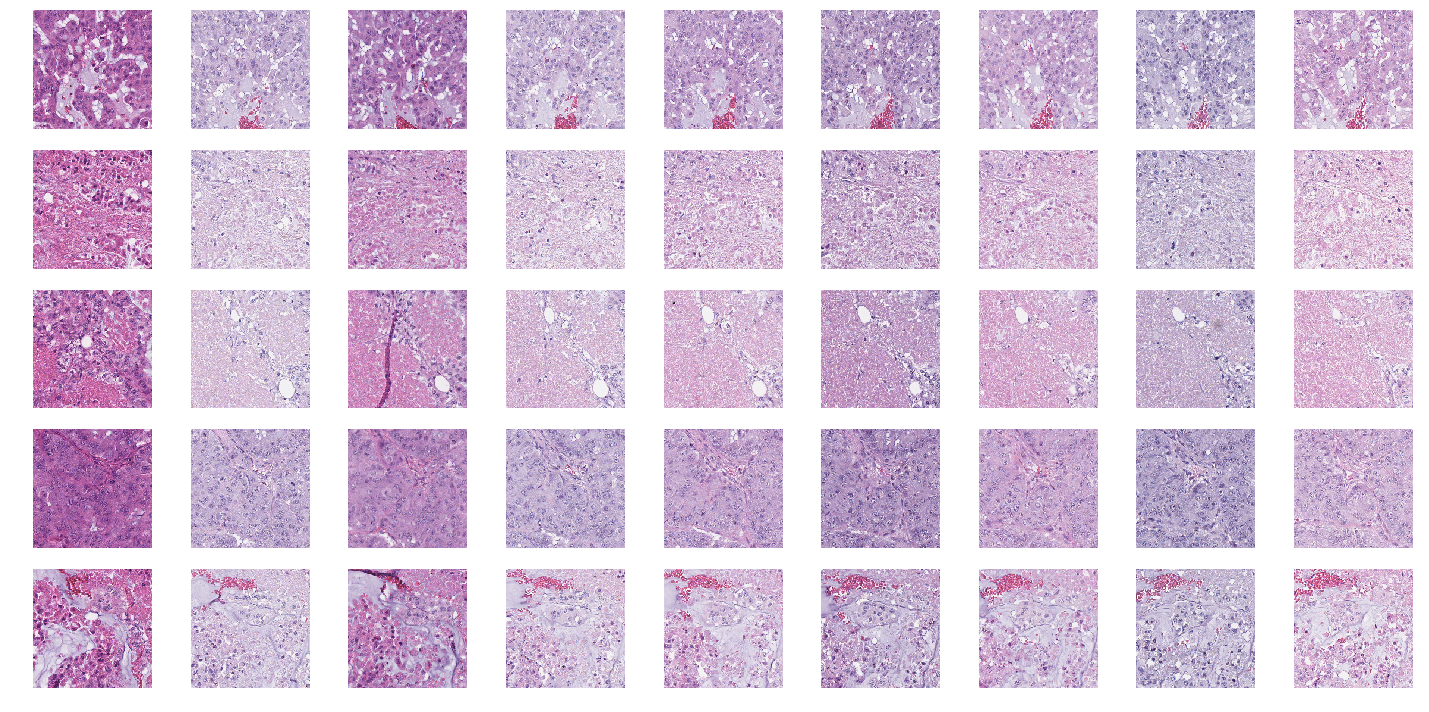

Normalized Images


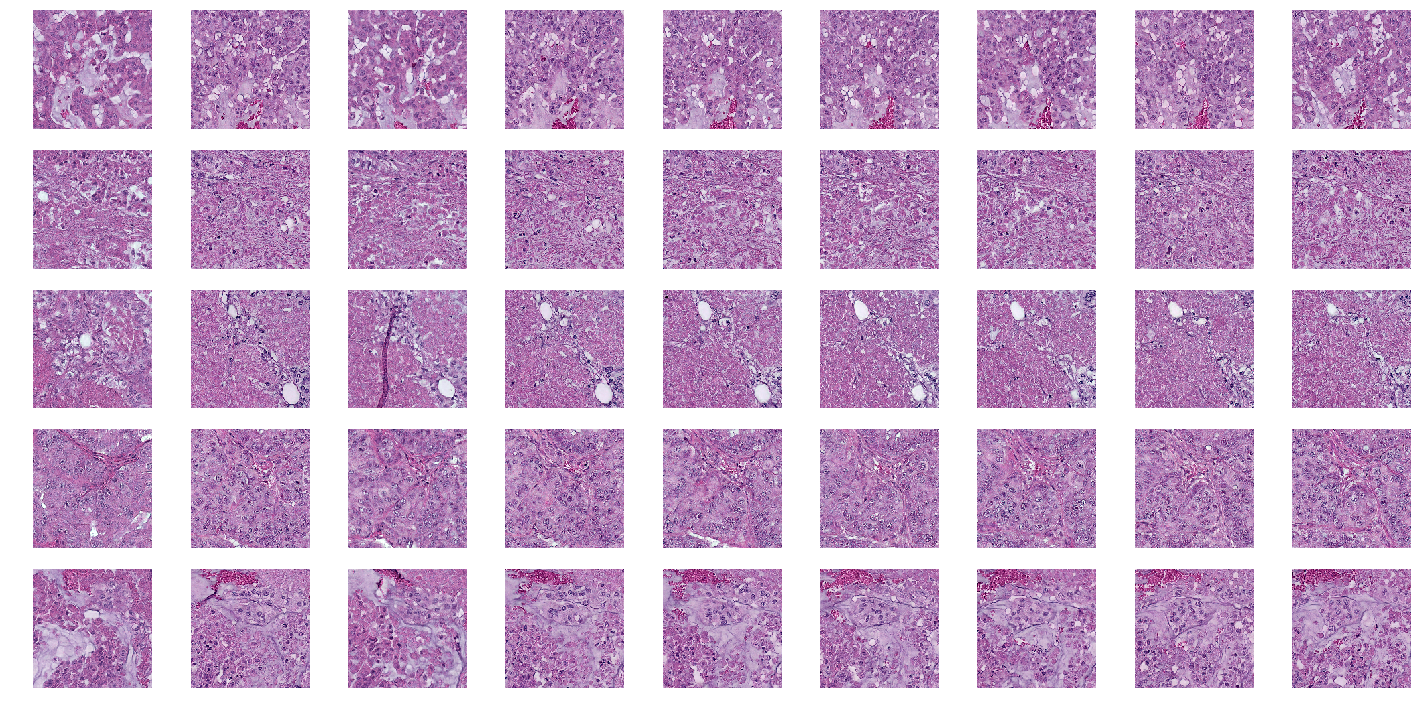

In [20]:
def plot_grid(slide, block, domain, X, selected_slide):
    fig, axes = plt.subplots(5,9,figsize=(20,10))
    for s_,b,d,x in zip(slide, block,domain,X):
        if s_ != selected_slide: continue
        axes[b-1,d-1].imshow(x[::5,::5]/255)
        axes[b-1,d-1].axis("off")
    plt.tight_layout(w_pad=0.01,h_pad=0.01)

for s in np.unique(slide):
    print("Input Images")
    plot_grid(slide, block, domain, X, s)
    plt.show()
    print("Normalized Images")
    plot_grid(slide, block, domain, X_normed, s)
    plt.show()
    break

# References

1. Bug, Daniel, et al. "Context-based Normalization of Histological Stains using Deep Convolutional Features." Deep Learning in Medical Image Analysis and Multimodal Learning for Clinical Decision Support. Springer, Cham, 2017. 135-142. [arxiv.org/abs/1708.04099](https://arxiv.org/abs/1708.04099)